In [ ]:
# This is for reading in S/N files and making 2D sensitivity maps

# Created 2019 Oct 29 by E.S.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

In [2]:
# LMIR plate scale

ps_LMIR = 0.0107 # asec/pix

In [3]:
noise_data = pd.read_csv(
    "data/test_csv_file_all_iterations_afternoon_of_20191124_number01.csv")

In [4]:
# initialize an array of NaNs for mapping 2D data onto it
# note this needs to be oversampled relative to the science frames

### read in a test science array here to determine size

oversample_factor = 10 # oversample by this much

# effective plate scale on the display area
pseudo_ps_LMIR = np.divide(ps_LMIR,oversample_factor)

# make the array with an odd number of pixels to have a center
dummy_array_0 = np.nan*np.ones((1001,1001))

In [157]:
noise_data["angle_deg"] = np.array([23,145,220,310])

In [143]:
noise_data

,Unnamed: 0,angle_deg,rad_asec,ampl_linear_norm,host_ampl,signal,noise,s2n
0,0,23,0.3,0.001,1.165688e+09,627462.905498,185829.854581,3.376545
1,0,145,0.4,0.001,1.165688e+09,427661.149783,176554.267659,2.422265
2,0,220,0.2,0.001,1.165688e+09,79059.513041,109357.399583,0.722946
3,0,310,0.1,0.001,1.165688e+09,-15790.156782,52091.201292,-0.303125


In [144]:
# fake data

'''
noise_data2 = pd.DataFrame()
noise_data2["angle_deg"] = 360.*np.random.random(size=50)
noise_data2["rad_asec"] = 0.45*np.random.random(size=50)
noise_data2["signal"] = np.random.random(size=50)
'''

'\nnoise_data2 = pd.DataFrame()\nnoise_data2["angle_deg"] = 360.*np.random.random(size=50)\nnoise_data2["rad_asec"] = 0.45*np.random.random(size=50)\nnoise_data2["signal"] = np.random.random(size=50)\n'

In [5]:
# function to convert radial data to xy, where target is in south
# (north is up (i.e., +y), degrees are E of N (i.e., CCW of +y axis))

def convert_rad_xy(canvas_array, PS, rho_asec, theta_deg):
    '''
    INPUTS:
    canvas_array: the array will will plot data on (and which you
        probably want to be oversampled)
    PS: effective plate scale for the display area (i.e., asec/pixel)
    rho: array of radii (in asec)
    theta_deg: array of angles E of N (in degrees)
    '''
    
    # find the center of the dummy array; this will be the pivot point
    array_center = (int(0.5*np.shape(dummy_array_0)[0]),
                    int(0.5*np.shape(dummy_array_0)[1]))
    
    # find x, y offsets from center in units of display pixels
    offset_from_center_x = -np.divide(rho_asec,PS)*np.sin(np.multiply(theta_deg,np.pi/180.))
    offset_from_center_y = np.divide(rho_asec,PS)*np.cos(np.multiply(theta_deg,np.pi/180.))
    
    # find absolute coordinates
    y_absolute = np.add(array_center[0],offset_from_center_y)
    x_absolute = np.add(array_center[1],offset_from_center_x)
    
    return y_absolute, x_absolute

In [6]:
y_scatter, x_scatter = convert_rad_xy(dummy_array_0, 
                              PS=pseudo_ps_LMIR, 
                              rho_asec=noise_data["rad_asec"], 
                              theta_deg=noise_data["angle_deg"])

# Make a scatter plot of points with variable coloration

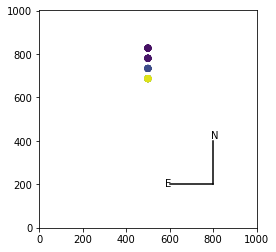

In [7]:
plt.scatter(x_scatter, y_scatter, c = noise_data["signal"])
#plt.scatter(500,500)
plt.ylim([0,np.shape(dummy_array_0)[0]])
plt.xlim([0,np.shape(dummy_array_0)[1]])
plt.annotate("N", xy=(790,410), xytext=(790,410))
plt.annotate("E", xy=(580,190), xytext=(580,190))
plt.plot([800,800],[200,400], color="k") # compass rose
plt.plot([800,600],[200,200], color="k") # compass rose
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Make a contour plot where regions between points are interpolated

In [8]:
# make meshgrid

x_mgrid_range = np.arange(0,np.shape(dummy_array_0)[1])
y_mgrid_range = np.arange(0,np.shape(dummy_array_0)[0])
xx, yy = np.meshgrid(x_mgrid_range, y_mgrid_range, sparse=False)

In [9]:
# interpolate between the empirical points

grid_z0 = griddata(points=np.transpose([x_scatter,y_scatter]), 
                   values=noise_data["signal"].values, 
                   xi=(xx, yy), 
                   method='nearest')

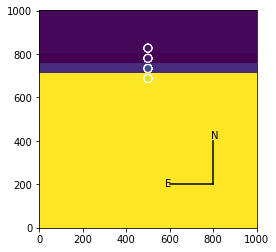

In [11]:
# 2D plot
plt.clf()
plt.imshow(grid_z0, origin="lower")

# compass rose
plt.annotate("N", xy=(790,410), xytext=(790,410))
plt.annotate("E", xy=(580,190), xytext=(580,190))
plt.plot([800,800],[200,400], color="k")
plt.plot([800,600],[200,200], color="k")

# overplot points
plt.scatter(x_scatter, y_scatter, s = 60, 
            c = noise_data["signal"], edgecolors="w")

# restrict dimensions
plt.ylim([0,np.shape(dummy_array_0)[0]])
plt.xlim([0,np.shape(dummy_array_0)[1]])
plt.gca().set_aspect('equal', adjustable='box')

#plt.savefig("junk_2d_first_contrast_curve.pdf")
plt.show()